# Demonstration: Latent space representation

In [1]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading
from jax.example_libraries import optimizers

In [2]:
import sys
sys.path.insert(0, '../')

import vqe as vqe
import losses as losses
import autoencoder as aut

In [3]:
import pandas as pd
import plotly.express as px

In [4]:
ae = aut.autoencoder(vqe.load_vqe('../data/vqes/ANNNI/N6n10'), aut.autoencoder_circuit)

Cost: 0.21326661109924316 | Mean F. 0.786733090877533: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:45<00:00,  9.44it/s]


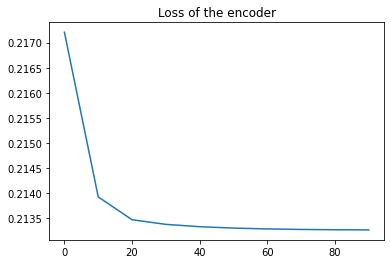

In [10]:
ae.train(.1, 1000, np.arange(100), circuit=False, plot=True)

In [11]:
def show_latent_space(aeclass):
    @qml.qnode(aeclass.device, interface="jax")
    def q_latent_probs(vqe_p, auto_p):
        aeclass.circuit(vqe_p, auto_p, decode = False)

        # return <psi|H|psi>
        return [qml.probs(wires = int(tr)) for tr in aeclass.wires_trash]

    jv_q_latent_probs = jax.jit(jax.vmap(lambda x, p : q_latent_probs(x, p), in_axes=(0,None)))

    latent_vectors = jv_q_latent_probs(aeclass.vqe.vqe_params0, aeclass.params)
    
    x = latent_vectors[:,0,0]
    y = latent_vectors[:,1,0]
    z = latent_vectors[:,2,0]
    
    c = []
    for label in ae.vqe.Hs.labels:
        if (label == [0,1]).all():
            c.append('green')
        elif (label == [0,0]).all():
            c.append('red')
        elif (label == [1,0]).all():
            c.append('blue')
        else: c.append('black')
    
    lv_df = pd.DataFrame(np.column_stack((x,y,z)),columns=['x','y','z'])
    fig = px.scatter_3d(lv_df, x='x', y='y', z='z', color=c)
    fig.show()
    

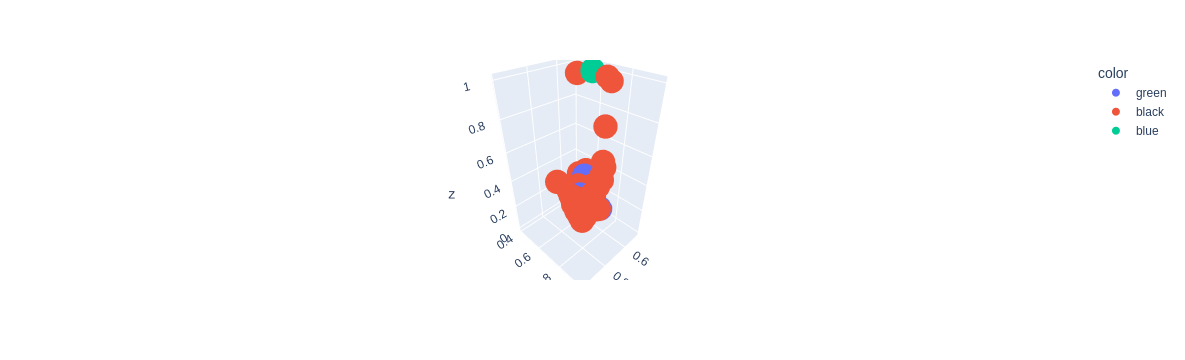

In [12]:
show_latent_space(ae)